# MNIST Digits Classification (LeNet)

### MNIST database (http://yann.lecun.com/exdb/mnist/)

In [1]:
%matplotlib inline
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import time

In [2]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    pinMem = True # Flag for pinning GPU memory
    print('GPU is available!')
else:
    pinMem = False

GPU is available!


### Downloading datset

In [3]:
apply_transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor()])
trainLoader = torch.utils.data.DataLoader(datasets.MNIST('./MNIST/', train=True, download=True,
                                                         transform = apply_transform), batch_size=64, shuffle=True, num_workers=1, pin_memory=pinMem)
testLoader = torch.utils.data.DataLoader(datasets.MNIST('./MNIST/', train=False,transform=apply_transform),
                                         batch_size=64, shuffle=True, num_workers=1, pin_memory=pinMem)

In [4]:
# Size of train and test datasets
print('No. of samples in train set: '+str(len(trainLoader.dataset)))
print('No. of samples in test set: '+str(len(testLoader.dataset)))

No. of samples in train set: 60000
No. of samples in test set: 10000


### Define network architecture

In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2_drop(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

### Initialize the network

In [6]:
net = LeNet()
print(net)

if use_gpu:
    net = net.cuda()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Total number of trainable parameters

In [7]:
totalParams = 0
for params in net.parameters():
    print(params.size())
    totalParams += np.sum(np.prod(params.size()))
print('Total number of parameters: '+str(totalParams))

torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])
Total number of parameters: 61706


In [8]:
init_conv1 = copy.deepcopy(net.conv1.weight.data)

### Define loss function and optimizer

In [9]:
criterion = nn.NLLLoss() # Negative Log-likelihood
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # Stochastic gradient descent with momentum

### Train the network

Iteration: 1 /10  ;  Training Loss: 0.019197 ; Testing Acc: 94.140 ; Time consumed: 0m 15s 
Iteration: 2 /10  ;  Training Loss: 0.005723 ; Testing Acc: 96.660 ; Time consumed: 0m 13s 
Iteration: 3 /10  ;  Training Loss: 0.004244 ; Testing Acc: 97.350 ; Time consumed: 0m 15s 
Iteration: 4 /10  ;  Training Loss: 0.003547 ; Testing Acc: 97.960 ; Time consumed: 0m 14s 
Iteration: 5 /10  ;  Training Loss: 0.003129 ; Testing Acc: 98.120 ; Time consumed: 0m 16s 
Iteration: 6 /10  ;  Training Loss: 0.002865 ; Testing Acc: 98.070 ; Time consumed: 0m 16s 
Iteration: 7 /10  ;  Training Loss: 0.002624 ; Testing Acc: 98.450 ; Time consumed: 0m 16s 
Iteration: 8 /10  ;  Training Loss: 0.002536 ; Testing Acc: 98.440 ; Time consumed: 0m 16s 
Iteration: 9 /10  ;  Training Loss: 0.002398 ; Testing Acc: 98.630 ; Time consumed: 0m 17s 
Iteration: 10 /10  ;  Training Loss: 0.002342 ; Testing Acc: 98.630 ; Time consumed: 0m 17s 
Training completed in 2m 34s


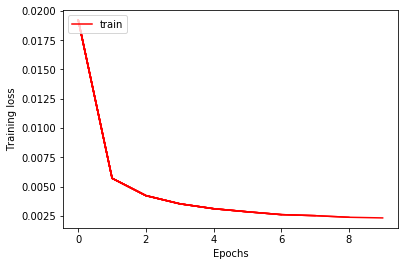

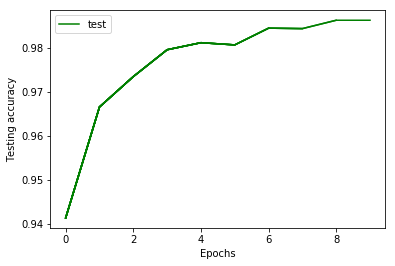

In [10]:
iterations = 10
trainLoss = []
testAcc = []
start = time.time()
for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0    
    net.train(True) # For training
    for data in trainLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)         
        # Initialize gradients to zero
        optimizer.zero_grad()
        # Feed-forward input data through the network        
        outputs = net(inputs)
        # Compute loss/error
        loss = criterion(outputs, labels)
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.item()
    avgTrainLoss = runningLoss/60000.0
    trainLoss.append(avgTrainLoss)
    
    # Evaluating performance on test set for each epoch
    net.train(False) # For testing [Affects batch-norm and dropout layers (if any)]
    running_correct = 0
    for data in testLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs = Variable(inputs.cuda())
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu()
        else:
            inputs = Variable(inputs)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum()
    avgTestAcc = running_correct.item()/10000.0
    testAcc.append(avgTestAcc)
        
    # Plotting training loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r-',label='train')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Training loss')   
    # Plotting testing accuracy vs Epochs
    fig2 = plt.figure(2)        
    plt.plot(range(epoch+1),testAcc,'g-',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Testing accuracy')    
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,avgTestAcc*100,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))

### Visualizing the kernels

In [11]:
# functions to show an image
def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

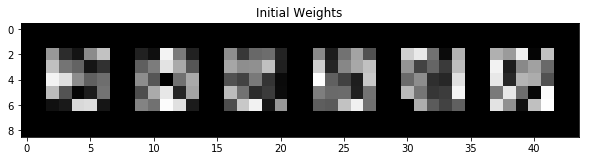

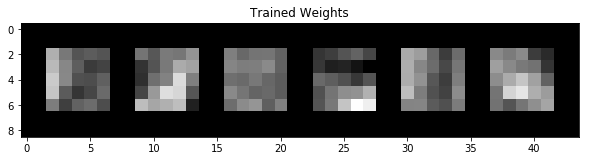

In [12]:
trained_conv1 = net.conv1.weight.data
if use_gpu:
    init_conv1 = init_conv1.cpu()
    trained_conv1 = trained_conv1.cpu()   
        
imshow(torchvision.utils.make_grid(init_conv1,nrow=6,normalize=True),'Initial Weights')
imshow(torchvision.utils.make_grid(trained_conv1,nrow=6,normalize=True),'Trained Weights')

### Saving the trained model

In [13]:
torch.save(net.state_dict(), 'trainedNet.pt') # Saving the trained parameters

### Loading saved model

In [14]:
new_net = LeNet()
new_net.load_state_dict(torch.load('trainedNet.pt'))